<br>
<img src="logoMoSEF.jpeg" width=90px align="left">
<div align="right">Enseignant : Rania Kaffel</div>
<div align="right">Réalisé par : Gaoussou DIAKITE et Eunice KOFFI</div>
<div align="right">Année : 2022/2023</div><br><br><br>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:32px;color:darkgreen">Master 2 Modélistaion Statistiques Economiques et Financières</span></div><br>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:28px;color:#e60000">Projet Finance Quantitative</span></div><br><br>
<hr>

<br>

<div align="center"><span style="font-family:Lucida Caligraphy;font-size:32px;color:darkgreen">Partie 4.2: « D » Portfolio construction and monitoring: ARIMA Model </span></div><br>
<hr>

## Stock Market Forecasting

In [14]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import plotly.express as px

plt.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [15]:
df1 = pd.read_excel(r'data/Data_projet.xlsx', sheet_name="Returns")
stock=df1
stock.head(3)

,Dates,Dates Future,BP/ LN Equity - Energy,STERV FH Equity - Basic Materials,IP US Equity - Basic Materials,UPM FH Equity - Basic Materials,NEM US Equity - Basic Materials,XOM US Equity - Energy,VLO US Equity - Energy,NUE US Equity - Basic Materials,...,MRO US Equity - Energy,WMB US Equity - Energy,CTRA US Equity - Energy,APA US Equity - Energy,EOG US Equity - Energy,KMI US Equity - Energy,EQT US Equity - Energy,HAL US Equity - Energy,FANG US Equity - Energy,S5ENRS Index -
0,2017-09-30,2017-10-31,5.919372,10.909070,0.791975,11.038760,-3.599040,1.671139,2.547771,3.194147,...,4.867257,-5.031656,3.551402,-9.128740,3.413359,-4.926647,-4.138565,-7.147512,9.391588,-0.662957
1,2017-10-31,2017-11-30,-0.988737,-2.246577,-0.288225,0.068212,2.295354,0.855728,9.456333,-0.570638,...,4.711674,1.929825,4.700338,1.111917,2.453189,-4.859194,-4.657615,-2.246140,2.006346,1.762193
2,2017-11-30,2017-12-31,6.988426,3.931891,2.349408,3.580244,1.644609,0.420218,7.346415,11.226980,...,14.083560,6.062945,-1.208981,0.932345,5.463253,4.875217,-4.496644,17.455190,15.497210,4.883477


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
fig = px.imshow(stock.iloc[:, 3:59].corr(),
                labels=dict(x="Columns", y="Columns", color="Correlation"),
                color_continuous_scale=px.colors.diverging.RdBu_r)
fig.update_layout(width=1200, height=1200)
fig.show()

In [6]:
stock['Dates']=pd.to_datetime(stock.Dates,format='%Y%m%d', errors='ignore')

In [7]:
cols = ['Dates Future', 'S5ENRS Index - ']
stock.drop(cols, axis=1, inplace=True)
stock = stock.sort_values('Dates')
stock = stock.set_index('Dates')


In [8]:
stock.index = pd.to_datetime(stock.index)

In [11]:
liste = stock.columns.to_list()
#liste

In [117]:
#for col in stock.columns:
    #stock[col].plot(figsize=(5, 2))
    #plt.title(col)
    #plt.show()


In [63]:
col_name = "GLEN LN Equity - Basic Materials"
if col_name in stock.columns:
    fig = px.line(x=stock.index, y=stock[col_name], title=col_name)
    fig.update_layout(
        xaxis_title="Index",
        yaxis_title="Value",
        title={
            'text': col_name,
            'font': {'size': 16},
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }
    )
    fig.show(figsize=(5, 2))

In [64]:
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose

def plot_seasonal_decompose(result: DecomposeResult, title="Seasonal Decomposition"):
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=result.seasonal.index, y=result.observed, mode="lines"),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.trend.index, y=result.trend, mode="lines"),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.seasonal.index, y=result.seasonal, mode="lines"),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.resid.index, y=result.resid, mode="lines"),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=title, margin=dict(t=100), title_x=0.5, showlegend=False
        )
    )

result = seasonal_decompose(stock[col_name], model='additive')
plot_seasonal_decompose(result, title="Seasonal Decomposition of : "+ col_name)

## Time series forecasting with ARIMA

In [65]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [66]:
import warnings
warnings.filterwarnings('ignore')

l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(stock[col_name],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:454.28499412911833
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:370.44830547571826
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:398.0220467181486
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:944.2661129056563
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:377.4031866029476
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:372.1643618231186
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:307.5683989723833
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:295.57410679188024
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:449.2684161477148
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:364.9795357126981
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:391.2702503998961
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1628.2344521280152
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:379.2601407167232
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:366.8923882839724
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:309.28254844879336
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:288.95679417470166
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:485.0920500187823
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:392.2526683070436
ARIM

In [67]:
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)
print("Select the minimum AIC:  ", minimum)

Select the minimum AIC:   288.95679417470166


In [68]:
mod = sm.tsa.statespace.SARIMAX(stock[col_name],
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
#print(results.summary())
print(results.summary().tables[2])

Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.80   Prob(JB):                         0.95
Heteroskedasticity (H):               0.69   Skew:                            -0.01
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.27


- Ljung-Box : teste l'auto-corrélation d'ordre supérieur à 1. L'hypothèse nulle (H0) stipule qu'il n'y a pas auto-corrélation des erreurs d'ordre 1 à r. L'hypothèse alternative (H1) stipule qu'il y a auto-corrélation des erreurs d'ordre 1 à r. 
- test de Heteroscedasticite: 
H0 : Les résidus sont homoscédastiques
Ha : Les résidus sont hétéroscédastiques
- test de Jarque-Bera:  H_0: les données suivent une loi normale.
H_1: les données ne suivent pas une loi normale

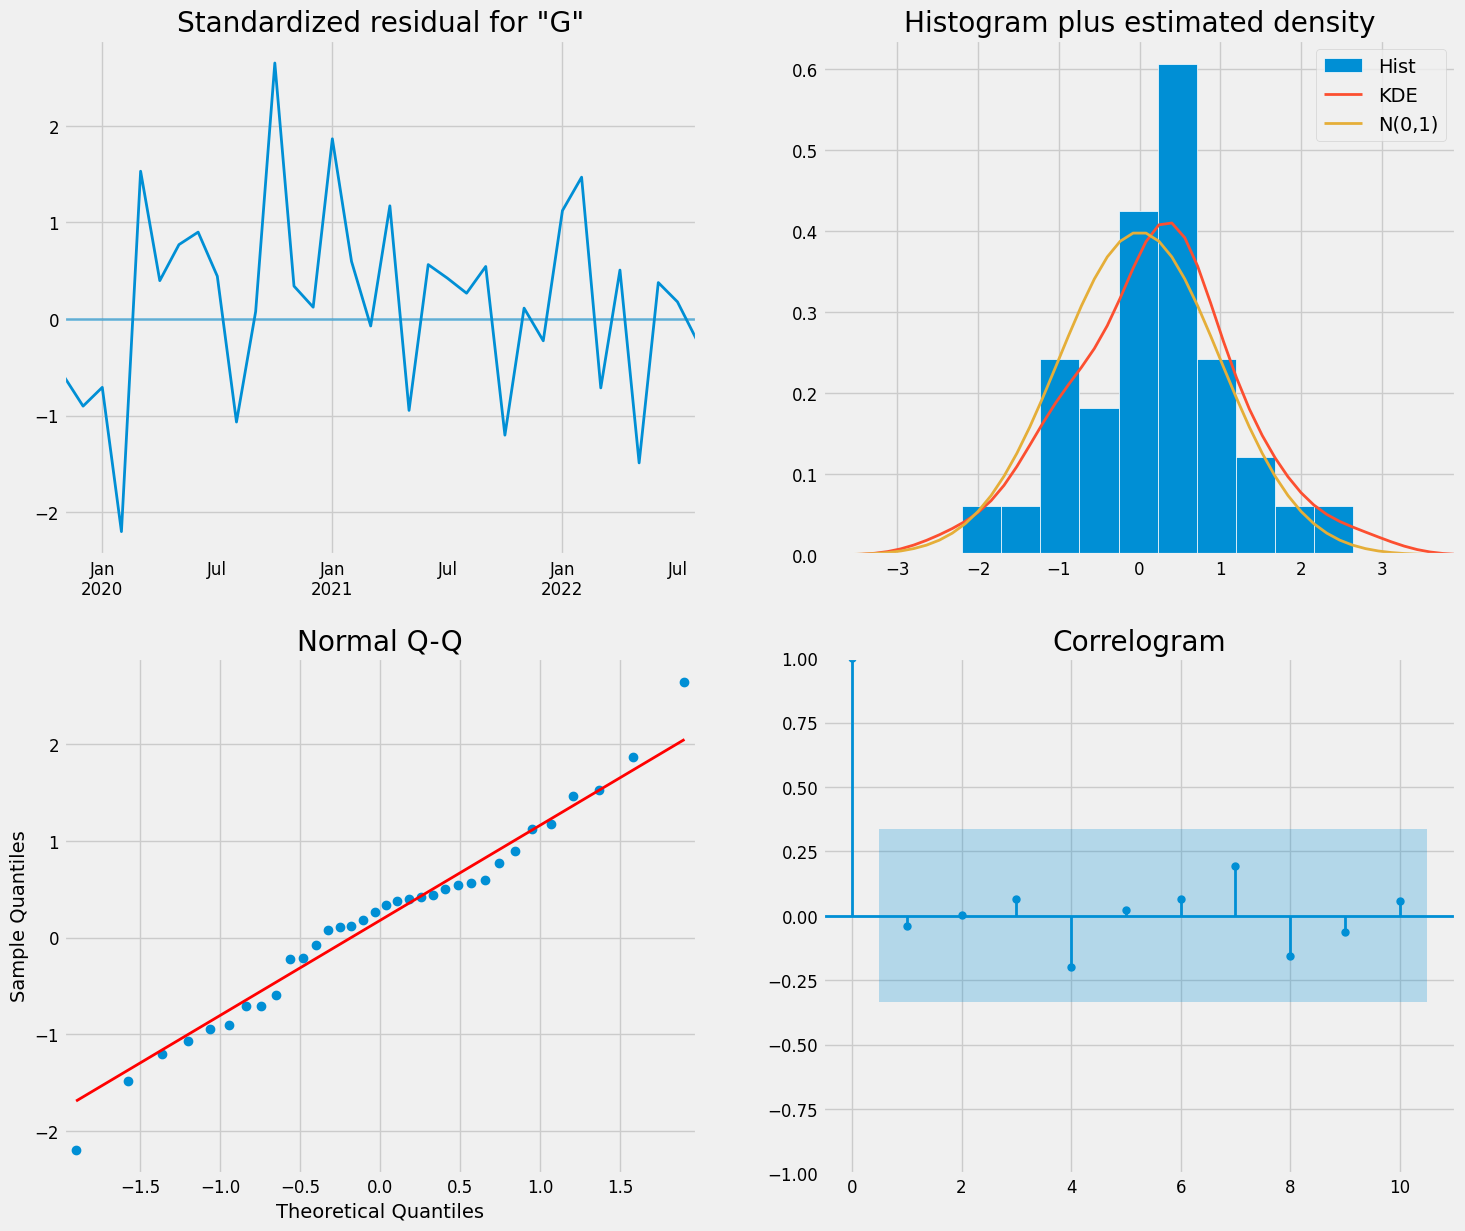

In [69]:
plt.rcParams['lines.linewidth'] = 2
results.plot_diagnostics(figsize=(16, 14))
plt.show()

## Validating forecasts

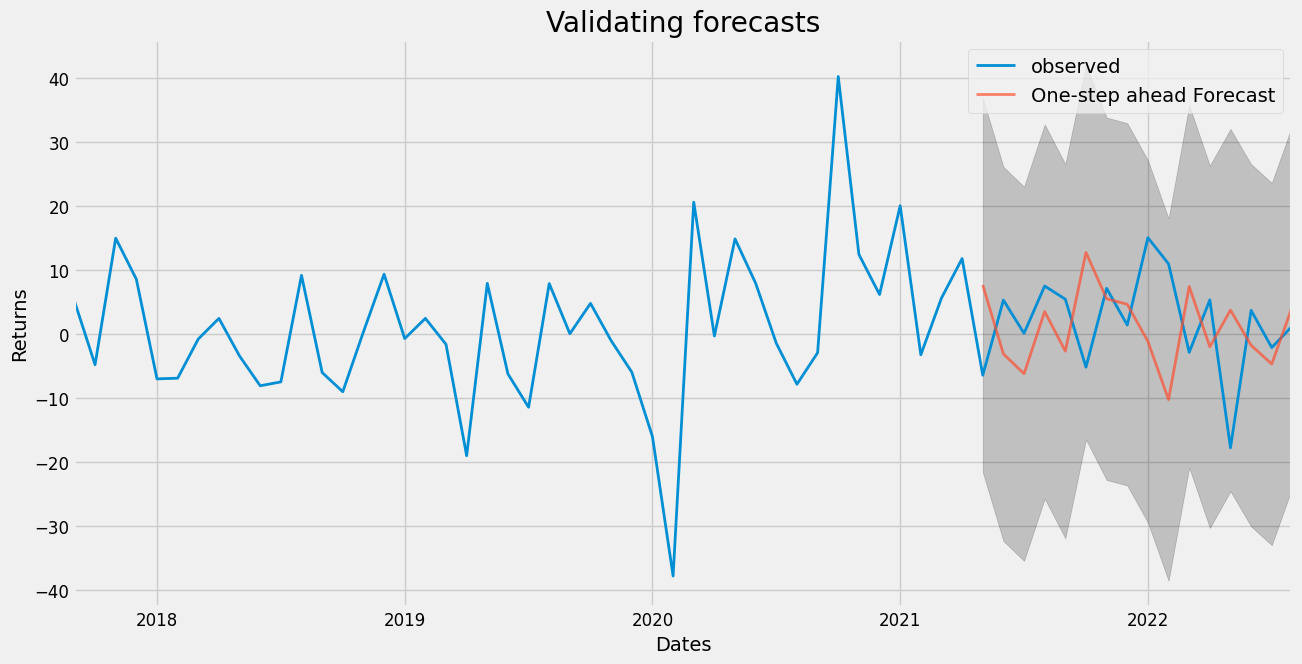

In [70]:
pred = results.get_prediction(start=pd.to_datetime('2021-05-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = stock[col_name]['2017-09-30':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Dates')
ax.set_ylabel('Returns')
plt.rcParams['lines.linewidth'] = 2
plt.legend()
plt.title("Validating forecasts")
plt.show()

In [71]:
y_forecasted = pred.predicted_mean
#years_return = stock[col_name]
y_truth = stock[col_name]['2021-05-31']

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 90.87
The Root Mean Squared Error of our forecasts is 9.53


En statistique, l'erreur quadratique moyenne (MSE) d'un estimateur mesure la moyenne des carrés des erreurs, c'est-à-dire la différence quadratique moyenne entre les valeurs estimées et ce qui est estimé. L'EQM est une mesure de la qualité d'un estimateur - elle est toujours non négative, et plus l'EQM est petite, plus nous nous rapprochons de la ligne de meilleur ajustement.

## Producing and visualizing forecasts

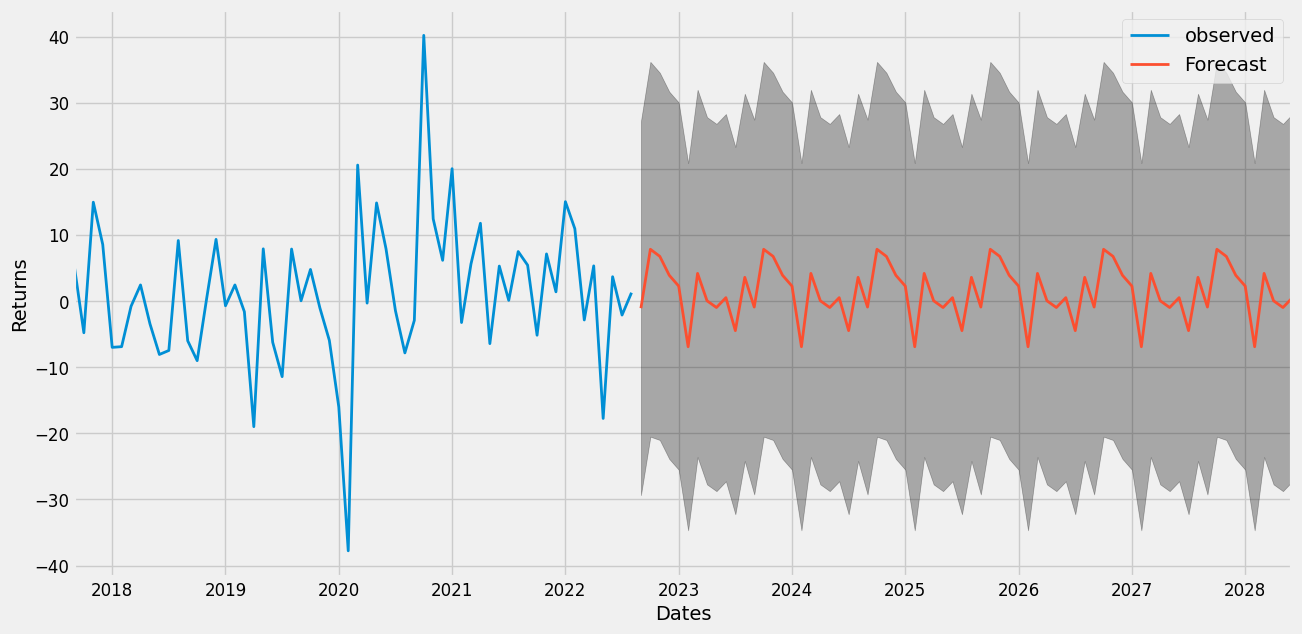

In [72]:
pred_uc = results.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()

ax = stock[col_name].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.3)
ax.set_xlabel('Dates')
ax.set_ylabel('Returns')
plt.rcParams['lines.linewidth'] = 2
plt.legend()
plt.show()

Les entreprises d'investissement, les fonds spéculatifs et même les particuliers utilisent des modèles financiers pour mieux comprendre le comportement du marché et réaliser des investissements et des transactions rentables. Une mine d'informations est disponible sous la forme d'historiques de cours des actions et de données sur les performances des entreprises, adaptées aux algorithmes d'apprentissage automatique à traiter.

Nous allons faire des analyses de séries chronologiques et des prévisions pour le marché boursier.
Cette étape comprend la suppression des colonnes dont nous n'avons pas besoin, la vérification des valeurs manquantes, le regroupement des returns par date.

Certains modèles distinctifs apparaissent lorsque nous traçons les données. La série chronologique a un modèle de saisonnalité
Nous pouvons également visualiser nos données à l'aide d'une méthode appelée décomposition de séries chronologiques qui nous permet de décomposer nos séries chronologiques en trois composantes distinctes : tendance, saisonnalité et bruit.
Le graphique montre clairement que le returns des actifs financiers est une série chronologique instable, ainsi que sa saisonnalité évidente.

Prévision de séries chronologiques avec ARIMA:
Nous allons appliquer l'une des méthodes les plus couramment utilisées pour la prévision des séries chronologiques, connue sous le nom d'ARIMA, qui signifie Autoregressive Integrated Moving Average.

Sélection des paramètres pour le modèle de série chronologique ARIMA. Les modèles ARIMA sont désignés par la notation ARIMA(p, d, q). Ces trois paramètres tiennent compte de la saisonnalité, de la tendance et du bruit dans les données.

Validation des prévisions:
Pour nous aider à comprendre l'exactitude de nos prévisions, nous comparons le return des actions prévu au return réel de la série temporelle, et nous fixons des prévisions pour qu'elles commencent le 2021-05-31 jusqu'à la fin des données.

Le tracé linéaire montre les valeurs observées par rapport aux prévisions de prévisions glissantes. Dans l'ensemble, nos prévisions s'alignent très bien sur les vraies valeurs, montrant une tendance à la  (hausse /baisse/ stable) commence dès le début de l'année.

En statistique, l'erreur quadratique moyenne (MSE) d'un estimateur mesure la moyenne des carrés des erreurs, c'est-à-dire la différence quadratique moyenne entre les valeurs estimées et ce qui est estimé. L'EQM est une mesure de la qualité d'un estimateur - elle est toujours non négative, et plus l'EQM est petite, plus nous nous rapprochons de la ligne de meilleur ajustement.

L'erreur quadratique moyenne (RMSE) nous indique que notre modèle a été en mesure de prévoir la performance d'actif dans l'ensemble de test.

Conclusion:
Notre modèle a clairement capturé la saisonnalité des returns proches. Alors que nous prévoyons plus loin dans l'avenir, il est naturel que nous devenions moins confiants dans nos valeurs. Cela se reflète dans les intervalles de confiance générés par notre modèle, qui augmentent à mesure que nous nous éloignons dans le futur.
